In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_60 import VitalSignsDataset,vital_pre_train
from model.lstm.autoencoder_v3_lstm import *
from model.lstm.autoencoder_v3_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

from torchsampler import ImbalancedDatasetSampler

2025-06-19 20:48:33.454545: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=32,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/baseline/resampled_60"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-3)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=300, save_dir=stage1_dir, patience=50,kl_warmup_epochs=240)

[VAE Pretrain] Epoch 50/300 Avg ELBO: -249.4736 (Recon: -249.5753, KLw: 0.1017)
[Epoch 100] KL weight: 0.0004, KL: 0.2228
[VAE Pretrain] Epoch 100/300 Avg ELBO: -329.1201 (Recon: -329.3429, KLw: 0.2228)
[VAE Pretrain] Epoch 150/300 Avg ELBO: -374.8258 (Recon: -375.1643, KLw: 0.3385)
[Epoch 200] KL weight: 0.0008, KL: 0.4442
[VAE Pretrain] Epoch 200/300 Avg ELBO: -410.2857 (Recon: -410.7299, KLw: 0.4442)
[VAE Pretrain] Epoch 250/300 Avg ELBO: -444.2286 (Recon: -444.7789, KLw: 0.5503)
[Epoch 300] KL weight: 0.0010, KL: 0.5675
[VAE Pretrain] Epoch 300/300 Avg ELBO: -465.2725 (Recon: -465.8400, KLw: 0.5675)


In [5]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [6]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=100,save_dir=stage2_dir,patience=50)

[SOM] Phase 1 Epoch 10/100 Avg Loss: 0.0733


[SOM] Phase 1 Epoch 20/100 Avg Loss: 0.0724
[SOM] Phase 1 Epoch 30/100 Avg Loss: 0.0727
[SOM] Phase 2 Epoch 40/100 Avg Loss: 0.0725
[SOM] Phase 2 Epoch 50/100 Avg Loss: 0.0721
[SOM] Phase 2 Epoch 60/100 Avg Loss: 0.0725
[SOM] Phase 3 Epoch 70/100 Avg Loss: 0.0704
[SOM] Phase 3 Epoch 80/100 Avg Loss: 0.0704
[SOM] Phase 3 Epoch 90/100 Avg Loss: 0.0707


In [7]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model2, train_loader, val_loader, train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 100,kappa= 1, beta= 10, eta= 1,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 263825


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Early stopping at epoch 27 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


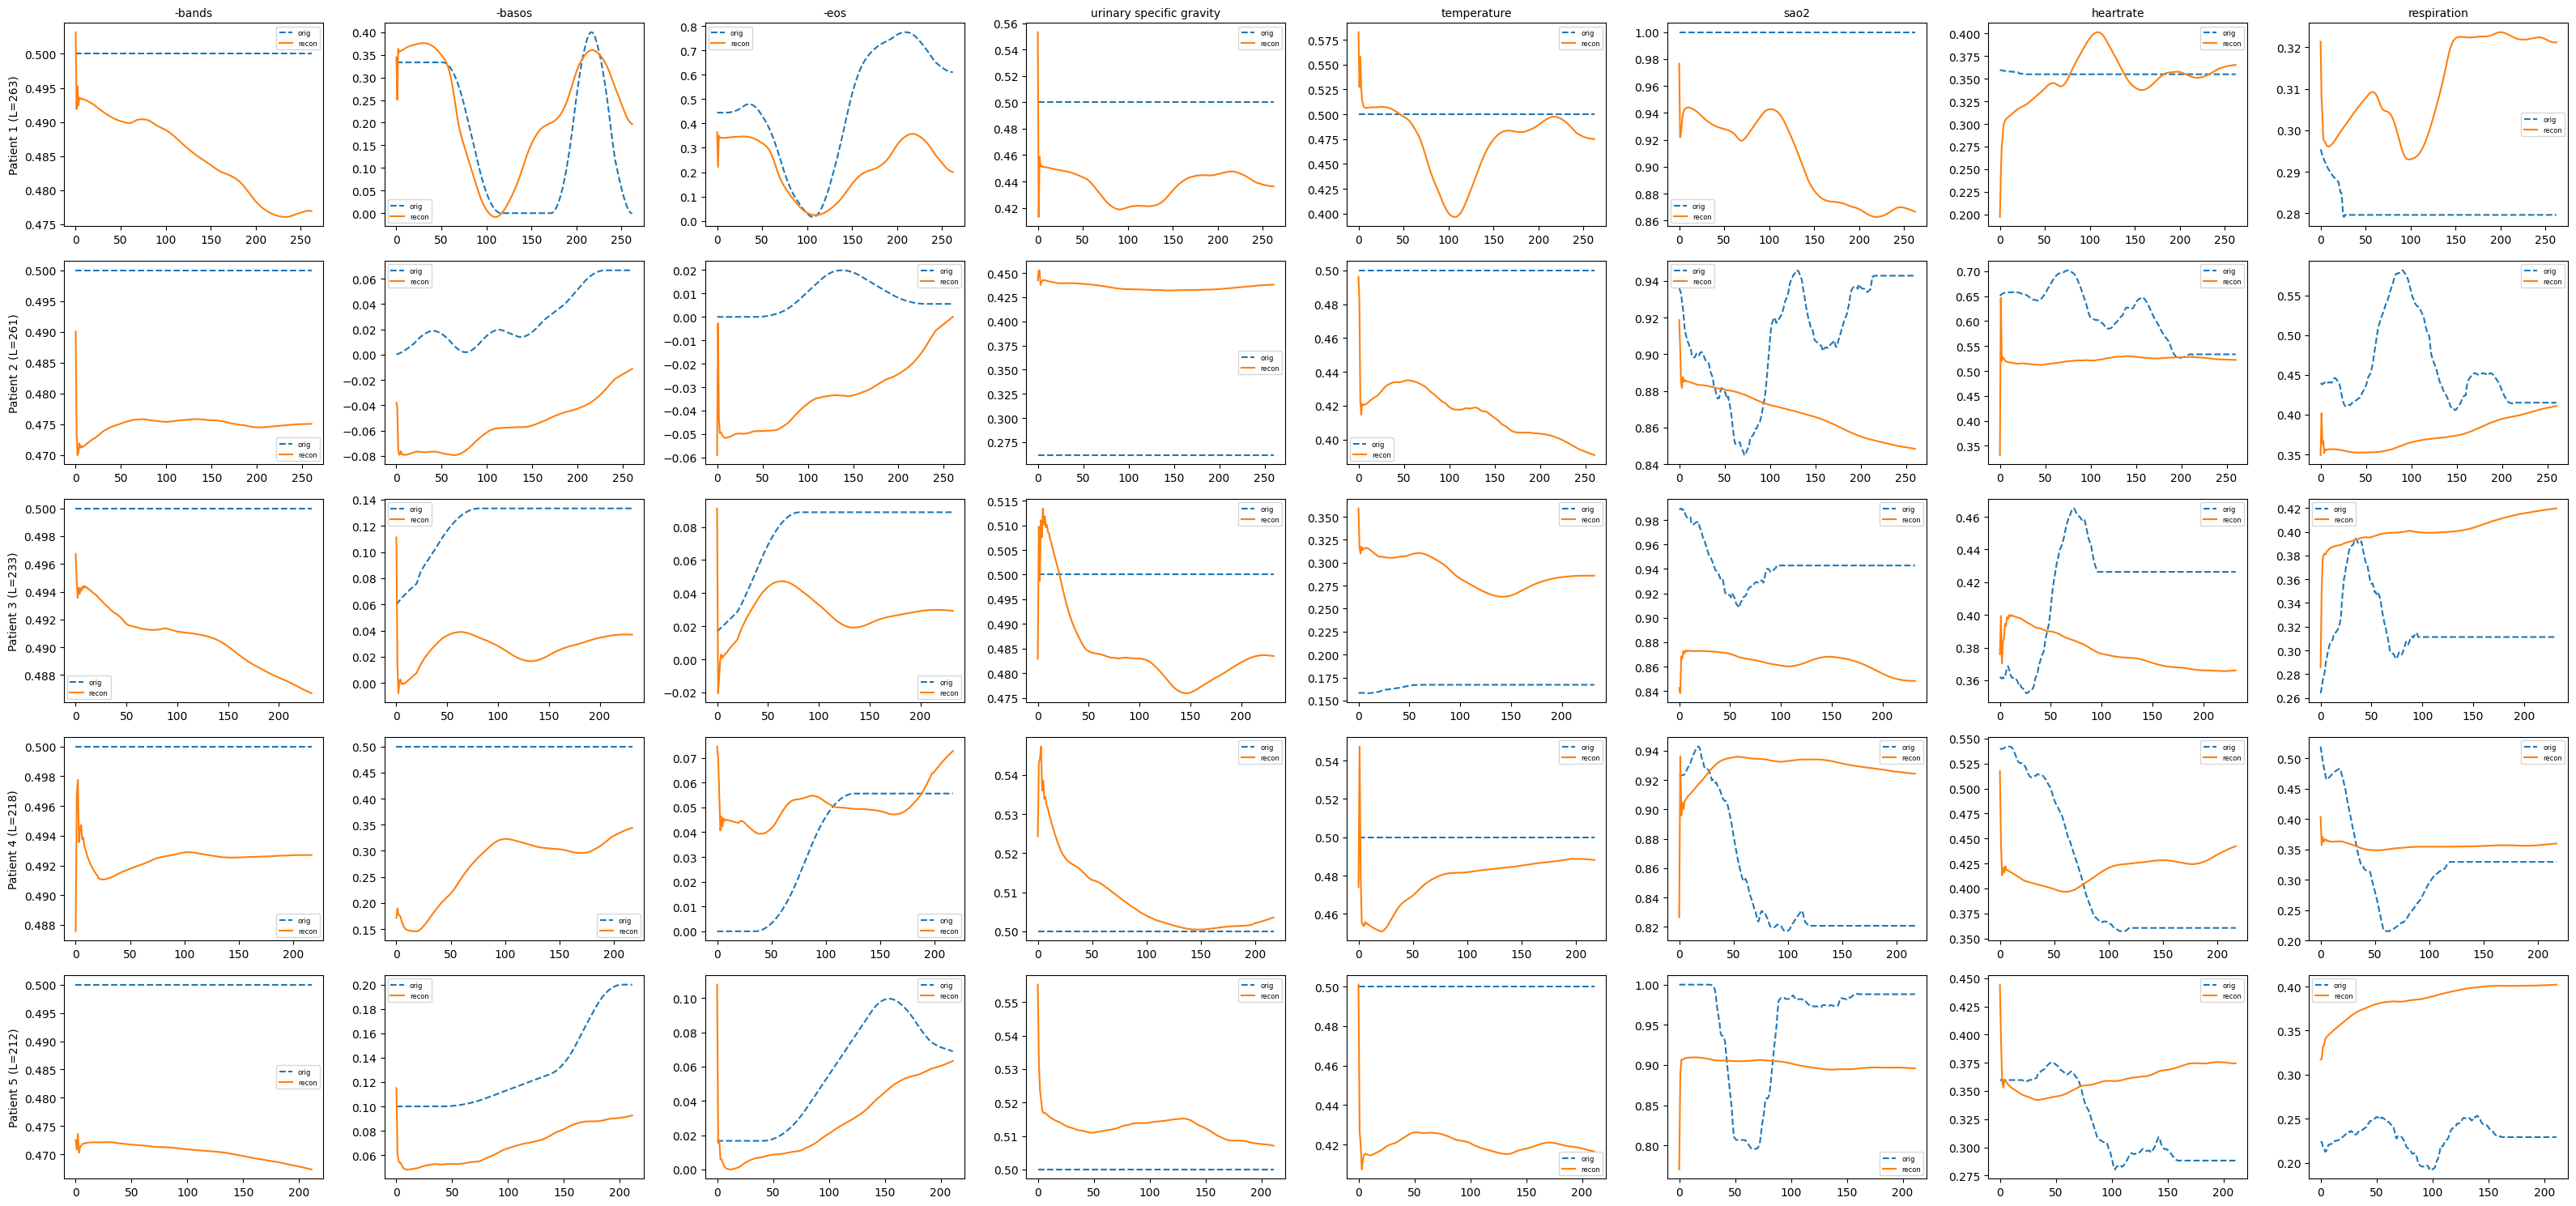

In [8]:
## 32
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]
selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 77785 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): -0.0795
  Std (overall): 0.5952
  Per-dim mean:
tensor([-7.6456e-02, -5.2927e-02,  4.6025e-01, -7.2561e-02, -1.3267e-01,
        -1.2870e-01,  1.9650e-01,  2.6122e-02,  9.9604e-02,  3.0477e-01,
         1.1924e-01,  3.3299e-02,  4.8240e-02, -1.8491e-01, -1.9612e+00,
         1.9968e-02,  1.2048e-02, -1.0509e-02,  2.7145e-02,  4.3993e-01,
        -2.2378e-01, -6.9585e-02,  4.1032e-02,  7.5782e-02,  1.8240e-01,
        -1.6092e-01,  2.1105e-01,  6.2823e-03, -1.5568e-01,  1.0404e-01,
         6.9107e-01,  3.4370e-01,  2.9407e-02, -1.2905e-01, -1.2462e-01,
        -1.4657e-01, -8.6595e-02,  3.1098e-01, -1.2314e-01, -7.9482e-01,
        -4.7872e-01,  1.4048e-01, -3.0662e-02, -8.6565e-02, -3.4084e+00,
        -1.0127e-01,  1.0013e-02,  1.8694e-01, -7.9725e-02, -3.3543e-03,
        -1.0654e+00,  4.0855e-02,  7.0474e-02,  5.5196e-02, -3.3332e-01,
         5.9126e-02, -6.4210e-02, -1.

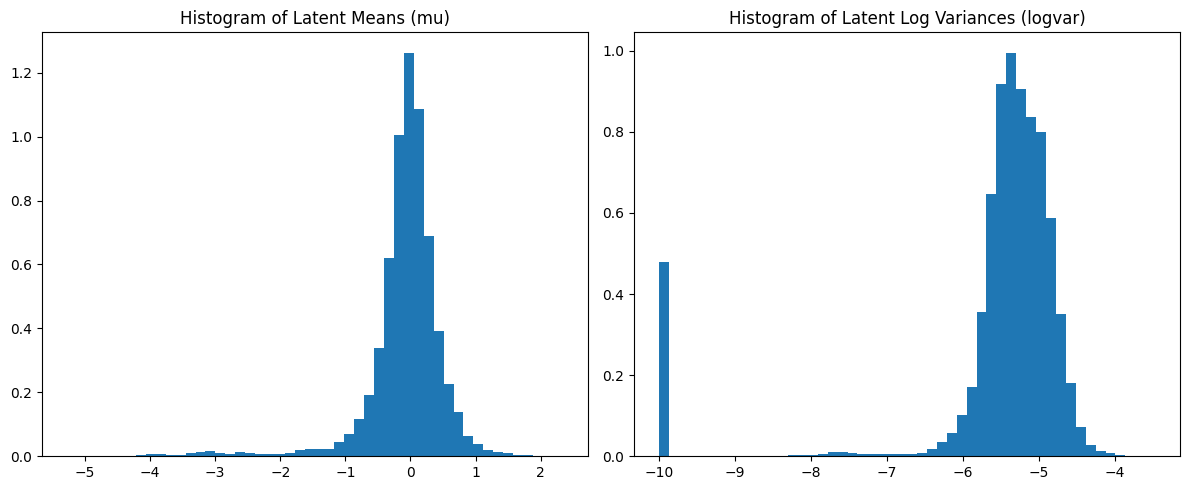

In [9]:
analyze_latent_stats(model3,train_loader, device, num_batches_to_analyze=20)

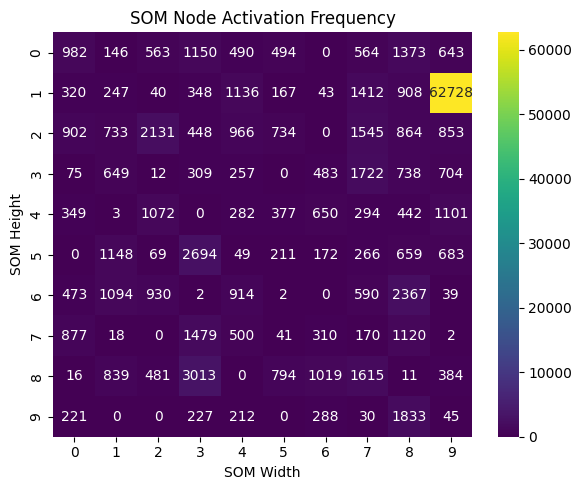

In [10]:
activation_map = compute_som_activation_heatmap(model3, test_loader, device)
plot_som_activation_heatmap(activation_map)

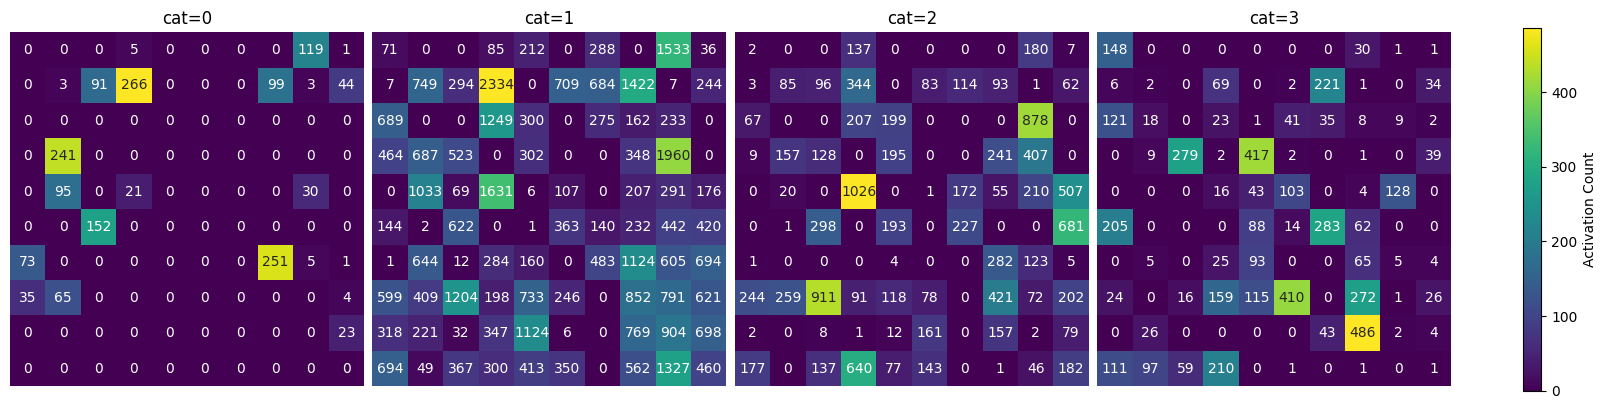

In [11]:
som_dim = (10,10)
hm_by_cat = compute_som_activation_by_category(model3, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

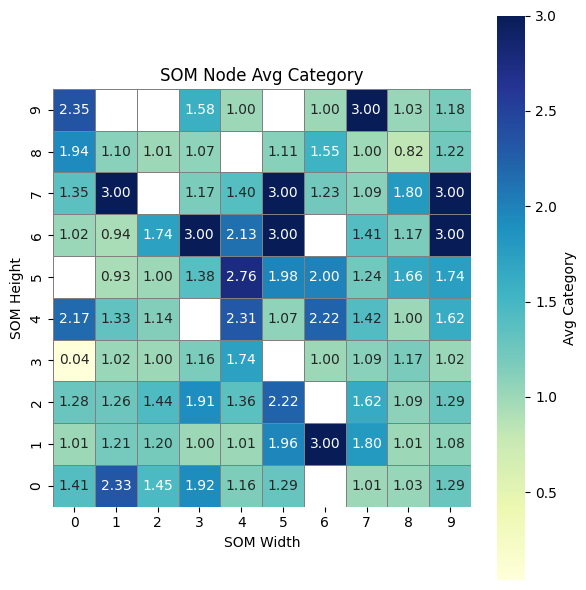

In [12]:
som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model3, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)